### Analysis of flow cytometry data

The [flow cytometry data file standard](https://bioconductor.org/packages/release/bioc/vignettes/flowCore/inst/doc/fcs3.html) (.fcs) provides the specifications needed to describe flow cytometry data sets containing the experimental data. A standard file format allows files created on one type of instrument (In our example, the BD FACSAria™ III Cell Sorter) to be read and analyzed by software implemented on a different computer.

There are various softwares available in GUI and command-line available to analyse these .fcs files. Here we will be using Flowkit, a Python toolkit for flow cytometry analysis and visualization. While Python is powerful, it doesn’t include all the tools needed for tasks like data visualization or complex math operations. That’s where packages come in—they extend Python’s capabilities.

#### Examples on how to import packages

Basic import of packages

In [ ]:
import pandas

Import with alias

In [ ]:
import pandas as pd

Import specific function or classes from a package

In [ ]:
from bokeh.plotting import show

Here are the packages that are needed to run Flowkit

In [ ]:
import copy
import bokeh
from bokeh.plotting import show
import flowkit as fk

Here are the common packages used to run basic analysis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt

Apart from importing packages, it is a great practice to carry out some configuration on our notebook. By default, Bokeh may try to open plots in a separate browser tab. We could prevent this by telling it to render its plots directly inside the Jupyter notebook.

In [ ]:
bokeh.io.output_notebook()

Lastly, it is also great to identify the directory of this notebook. This helps with identifying the path while importing your files in your downstream analysis. The '!' tells the notebook that it is not a Python code and it will run it as a shell command. 'pwd' is a shell command that stands for 'print working directory' and this will show you your current working directory.

In [ ]:
! pwd

First, we have to import the .fcs files.

In [ ]:
sample = fk.Sample('../doc/Specimen_001_pSBeF1a_A_004.fcs')

In addition to importing the .fcs files, we want to remove the file extension from the sample names.

In [ ]:
sample.replace('.fcs', '')

Now, you are ready to start your analysis.

In [3]:
import copy
import bokeh
from bokeh.plotting import show
import flowkit as fk

import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt

bokeh.io.output_notebook()
%matplotlib inline

Loading BokehJS ...

In [2]:
! pwd

/projects/health_sciences/bms/biochemistry/lim_group/gab/2024/facs/2024/020824_TFN_060824_FACS


Usually, we would have multiple files from an experiment. To make this more efficient, we could import multiple .fcs files and remove the file extension at the same time by creating a loop.

In [6]:
samples = []
for i in glob('../doc/*.fcs'):
    sample = fk.Sample(i, sample_id = i.replace('.fcs',''))
    samples.append(sample)
print(samples)

[Sample(v3.1, Specimen_001_pSBeF1a_C_006, 10 channels, 120877 events), Sample(v3.1, Specimen_001_pSBeF1a_W_003, 10 channels, 111151 events), Sample(v3.1, Specimen_001_pSBeF1a_A_004, 10 channels, 121470 events), Sample(v3.1, Specimen_001_pSBeF1a_D_007, 10 channels, 128893 events), Sample(v3.1, Specimen_001_pSBeF1a_B_005, 10 channels, 134173 events)]


We will convert our samples as a pandas Dataframe 

In [7]:
df_events = sample.as_dataframe(source='raw')

We will make a scatterplot of our raw data.

To specify which file we want to view, we could place the number according to the list of samples. In this example, we are viewing the first file in the sample list by specifying '0'. 

In [8]:
f = samples[0].plot_scatter('FSC-A','SSC-A', source='raw')
show(f)

Each point in the scatterplot represents a single cell. The forward scatter-area (FSC-A) measures the total signal area, indicating its relative size while the side scatter-area (SSC-A) measures internal complexity or granularity of the cell. Together, this scatterplot allow us to isolate and gate for specific cell populations based on size and complexity.

To gate a certain population of cells, we will create an empty gating strategy. This act as a placeholder for our different gates.

In [ ]:
g_strat = fk.GatingStrategy()

There are multiple types of gates available within FlowKit, including
- RectangleGate
- PolygonGate
- EllipsoidGate
- QuadrantGate (and the related Quadrant class)
- BooleanGate

The first gate that we will be constructing is a PolygonGate. We have to first define the x- and y-axis of the scatterplot by defining dim_a and dim_b respectively and also the vertices of the rectangle based on the scatterplot. Once we have these information listed out, we will use the function 'fk.gates.PolygonGate'.

In [ ]:
gate_name = 'poly_size'
dim_a = fk.Dimension('FSC-A')
dim_b = fk.Dimension('SSC-A')
vertices = [(60000, 10000),
            (200000, 50000),
            (450000, 200000),
            (50000, 60000)]
poly_gate = fk.gates.PolygonGate(gate_name, dimensions=[dim_a, dim_b], vertices=vertices)

We can then add this first gate, 'poly1', to the gating place holder, 'g_strat'. 

In [ ]:
g_strat.add_gate(poly_gate, gate_path=('root',))

The first gate selects a subset of the cell population in each files based on their size and complexity. From this subset of cell, we need to exclude doublets and keep only true single cells. This is done by having a FSC-Area vs. FSC-Height (measures the peak signal height) scatterplot. Again, we will be using a PolygonGate but we would need to re-define the x- and y-axis and vertices.

In [ ]:
gate_name = 'poly_singlets'
dim_a = fk.Dimension('FSC-A')
dim_b = fk.Dimension('FSC-H')

vertices = [(40000,20000),
            (200000, 100000),
            (150000, 140000),
            (30000, 50000)]

poly_gate = fk.gates.PolygonGate(gate_name, dimensions=[dim_a, dim_b], vertices=vertices)

We will then add this second gate, 'poly2', after the first gate.

In [ ]:
g_strat.add_gate(poly_gate, gate_path=('root','poly_size'))

Next, we also want to select/gate for live cells. Prior to the flow cytometry run, L/D NIR was use to stain the cells. This stain helps us identify live cells. The channel that detects this stain is 'R_780/60-A'. A R_780/60-A vs. FSC-H scatterplot and a RectangleGate will be used to gate for live cells.

In [ ]:
gate_name = 'rect_live'
dim_a = fk.Dimension('R_780/60-A', range_min=-171, range_max=2000)
dim_b = fk.Dimension('FSC-H', range_min=0, range_max=215000)

rect_gate = fk.gates.RectangleGate(gate_name, dimensions=[dim_a, dim_b])

We can then add this third gate, 'rect_live', after the first  and second gate. 

In [ ]:
g_strat.add_gate(rect_gate, gate_path=('root', 'poly_size','poly_singlets'))

These first three gates help filter out unhealthy cells and we can now proceed with creating gates based on the fluorescent intensities of each cell. Prior to the flow cytometry run, these cells were transfected with two fluorescent reporters, sfCherry3C (Red) and mTagBFP2 (Blue), and the channels that detect these signals are 'YG_610/20-A' and 'BV421-A' respectively.

In [ ]:
# Gating for cells expressing only the blue reporter
dim_a = fk.Dimension('YG_610/20-A', range_min=0, range_max=2500)
dim_b = fk.Dimension('BV421-A', range_min=9000, range_max=1000000)

rect_gate = fk.gates.RectangleGate('rect_blue', dimensions=[dim_a, dim_b])
g_strat.add_gate(rect_gate, gate_path=('root', 'poly_size','poly_singlets','rect_live'))

In [ ]:
# Gating for cells expressing only the red reporter
dim_a = fk.Dimension('YG_610/20-A', range_min=90000, range_max=1000000)
dim_b = fk.Dimension('BV421-A', range_min=-265, range_max=6000)
rect_gate = fk.gates.RectangleGate('rect_red', dimensions=[dim_a, dim_b])
g_strat.add_gate(rect_gate, gate_path=('root', 'poly_size','poly_singlets','rect_live'))

In [ ]:
# Gating for cells expressing both reporters
dim_a = fk.Dimension('YG_610/20-A', range_min=5000, range_max=1000000)
dim_b = fk.Dimension('BV421-A', range_min=11000, range_max=1000000)
rect_gate = fk.gates.RectangleGate('rect_dp', dimensions=[dim_a, dim_b])
g_strat.add_gate(rect_gate, gate_path=('root', 'poly_size','poly_singlets','rect_live'))

Let's have a look at our gating hierachy

In [10]:
print(g_strat.get_gate_hierarchy(output='ascii'))

root
╰── poly_size
    ╰── poly_singlets
        ╰── rect_live
            ├── rect_blue
            ├── rect_red
            ╰── rect_dp


Next, we need to create a session class. The session class is intended as the main interface in FlowKit for complex flow cytometry analysis. In this step, we tell flowkit to use the gating strategy that we have just made and the samples that we imported. 

In [11]:
session = fk.Session(gating_strategy= g_strat, fcs_samples=samples)

We will get a list of our sample ids

In [12]:
sample_list = session.get_sample_ids()
sample_list

['Specimen_001_pSBeF1a_A_004',
 'Specimen_001_pSBeF1a_B_005',
 'Specimen_001_pSBeF1a_C_006',
 'Specimen_001_pSBeF1a_D_007',
 'Specimen_001_pSBeF1a_W_003']

We will apply the gating strategy to our samples.

In [13]:
session.analyze_samples(verbose=True)

#### Processing gates for 5 samples (multiprocessing is enabled - 5 cpus) ####
Specimen_001_pSBeF1a_A_004: processing gate poly_size
Specimen_001_pSBeF1a_A_004: processing gate poly_singlets
Specimen_001_pSBeF1a_A_004: processing gate rect_live
Specimen_001_pSBeF1a_B_005: processing gate poly_size
Specimen_001_pSBeF1a_A_004: processing gate rect_blue
Specimen_001_pSBeF1a_A_004: processing gate rect_red
Specimen_001_pSBeF1a_A_004: processing gate rect_dp
Specimen_001_pSBeF1a_B_005: processing gate poly_singlets
Specimen_001_pSBeF1a_C_006: processing gate poly_size
Specimen_001_pSBeF1a_B_005: processing gate rect_live
Specimen_001_pSBeF1a_C_006: processing gate poly_singlets
Specimen_001_pSBeF1a_B_005: processing gate rect_blue
Specimen_001_pSBeF1a_B_005: processing gate rect_red
Specimen_001_pSBeF1a_B_005: processing gate rect_dpSpecimen_001_pSBeF1a_C_006: processing gate rect_live

Specimen_001_pSBeF1a_C_006: processing gate rect_blue
Specimen_001_pSBeF1a_D_007: processing gate poly_si

Here are the results for healthy cells

In [14]:
results_report = session.get_analysis_report()
results_report[results_report['gate_name'] == 'rect_live']

,sample,gate_path,gate_name,gate_type,quadrant_parent,parent,count,absolute_percent,relative_percent,level
2,Specimen_001_pSBeF1a_A_004,"(root, poly_size, poly_singlets)",rect_live,RectangleGate,None,poly_singlets,46277,38.097473,100.0,2
8,Specimen_001_pSBeF1a_B_005,"(root, poly_size, poly_singlets)",rect_live,RectangleGate,None,poly_singlets,44778,33.373331,100.0,2
14,Specimen_001_pSBeF1a_C_006,"(root, poly_size, poly_singlets)",rect_live,RectangleGate,None,poly_singlets,45748,37.846737,100.0,2
20,Specimen_001_pSBeF1a_D_007,"(root, poly_size, poly_singlets)",rect_live,RectangleGate,None,poly_singlets,45377,35.205170,100.0,2
26,Specimen_001_pSBeF1a_W_003,"(root, poly_size, poly_singlets)",rect_live,RectangleGate,None,poly_singlets,45782,41.189013,100.0,2


In this example, we are only interested in cells that are expressing both reporters and that would be the gate 'rect_dp'. Remember, we have 5 different .fcs files in the sample list, so we have to create a loop to get the events from each files.

In [ ]:
dp_all = []
for i in sample_list:
    dp = session.get_gate_events(sample_id=i, gate_name='rect_dp')
    dp["Samples"] = i
    dp_all.append(dp)

We can now merge the data from all 5 .fcs files into a pandas DataFrame.

In [ ]:
df = pd.concat(dp_all)

We will use list comprehension to remove the second header because there are multiple headers.

In [ ]:
df.columns = [c[0] + "_" + c[1] for c in df.columns]

We will create a 'dictionary' to rename the samples for clarity and easier interpretation.

In [ ]:
names = {"Specimen_001_pSBeF1a_A_004":"uAUG_I",
         "Specimen_001_pSBeF1a_B_005":"uORF_I",
         "Specimen_001_pSBeF1a_C_006":"mAUG_I",
         "Specimen_001_pSBeF1a_D_007":"mORF_I",
         "Specimen_001_pSBeF1a_W_003":"Intronless"}

df["Sample_name"]= df.Samples_.apply(lambda x: names[x])

In this example, we are interested in the relative fluorescent intensity of Red to Blue and vice versa in each cell.

In [ ]:
df["RatioRB"] = df["YG_610/20-A_mCherry"]/df["BV421-A_TagBFP"]
df["RatioBR"] = df["BV421-A_TagBFP"]/df["YG_610/20-A_mCherry"]

We will remove infinities and zeroes to prevent errors.

In [ ]:
df = df[(df.RatioRB!=np.inf) & (df.RatioRB!=0)].sort_values("RatioRB")
df = df[(df.RatioBR!=np.inf) & (df.RatioBR!=0)].sort_values("RatioBR")

Finally, we will create a boxplot to visualise our data.

/tmp/ipykernel_2283089/1075764821.py:3: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-0.001, 10)


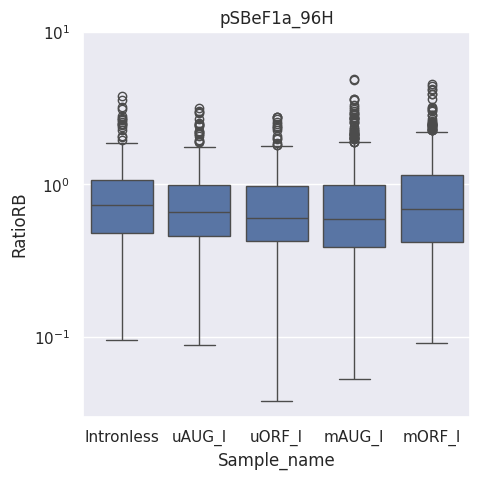

In [20]:
sns.boxplot(data=df, y="RatioRB", x="Sample_name", order=["Intronless","uAUG_I","uORF_I", "mAUG_I","mORF_I"])
plt.yscale('log')
plt.ylim(-0.001, 10)
sns.set(rc={'figure.figsize':(5,5)})
plt.title('pSBeF1a_96H')
plt.show()
#plt.savefig("051223_Transfection_facs_p4_ratiorb.png")